In [74]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import tkinter as tk
from tkinter import filedialog
from scipy import interpolate
from scipy import integrate
# import holoviews as hv
# hv.extension()

In [2]:
def params_dict(params):
    """
    set some default parameters into the params dict
    :return:
    """

    params_default = {'model': 'None', 'Edes': 50, 'beta': 3, 'nu': 1e+28, 'order': 0, 'A': 0, 'B': 0, 'C': 0, 'U': 0,
                      'monolayer': 1e15}
    for v in params:
        # params_default[k] = v
        params_default[v] = params[v]
    return params_default


def models(coverage, val, R, params):
    """
    Calculates dNdT for various models defined below
    :param model: Choices are: 'None', 'Linear', 'Albano', 'Modified Albano', 'Work Function', 'Power'
    :param params: parameters to the model
    :return: dNdT
    """
    prefactor = (params['nu'] / params['beta']) * (coverage ** params['order'])
    fractional_cov = coverage/params['monolayer']
    model_list = {'None': prefactor * np.exp(-params['Edes'] / (R * val)),
                  'Linear': prefactor * np.exp(-(params['Edes']- params['A']*fractional_cov) / (R * val)),
                  'Albano': prefactor * np.exp(-(params['Edes']-(9*(params['U']**2)*(fractional_cov**(3/2))/((1+9*params['A']*(fractional_cov**(3/2)))**2)))/(R * val)),
                  'Modified Albano': prefactor * np.exp(-(params['Edes'] - 9*((params['A']*fractional_cov + params['B'])**2)*(fractional_cov**(3/2))) / (R * val)),
                  'Work Function': prefactor * np.exp(-(params['Edes']- (params['A']*fractional_cov**3 + params['B']*fractional_cov**2 + params['C'] * fractional_cov))/ (R * val)),
                  'Power': prefactor * np.exp(-(params['Edes'] - params['A']*fractional_cov**params['B'])/ (R * val))
                  }
    try:
        # params['model'] = 'None'
        return model_list[params['model']]


    except ValueError as e:
        print('model not listed or used correctly. Check inputs')

# def polanyi_wigner(T, init_coverage, Edes, beta, order, nu=None, disp=False):
def polanyi_wigner(T, init_coverage, params, disp=False):
    # TODO unpack orders if multiple are given as args

    # nu, order = params['nu'], params['order']

    R = 8.314/1e3  # kj/molK
    order_dict = {0: 1e28, 0.5: 3e20, 1: 1e13, 2: 1e-2}
    # if params['nu'] is None:
    params['nu'] = order_dict.get(params['order'] , 1e13)

    params = params_dict(params)

    dNdT = np.zeros((T.shape[0], len(init_coverage)))

    coverage_lst = np.zeros((T.shape[0], len(init_coverage)))
    dT = np.concatenate(([0], np.diff(T)))
    # for looping over multiple coverages
    for idx1, coverage in enumerate(init_coverage):
        # for a particular coverage, loop over T
        for idx, val in enumerate(T):

            # TODO: issue for zero order in that at some point coverage = 0 but the exp decreases as T increases
            # dNdT[idx][idx1] = nu / (beta) * (coverage ** order) * np.exp(-Edes / (R * val))
            dNdT[idx][idx1] = models(coverage, val, R, params)



            # print(dNdT[idx][idx1])
            # dNdT[idx][idx1] = nu/(beta)*(np.float_power(coverage,order))*np.exp(-Edes/(R*val))

            # this may be needed for debugging:
            # if idx % 5 == 0:
            #     print(dNdT[idx][idx1])
            #     print('nu: {0}, \nbeta: {1},\ncoverage: {2},\nexp term: {3}, \nT: {4}'
            #           .format(nu, beta, coverage,np.exp(-Edes / (R * val)), val))
            if coverage <= 0:
                coverage = 0
                dNdT[idx][idx1] = 0
                coverage_lst[idx][idx1] = coverage
                break
            else:
                coverage_lst[idx][idx1] = coverage
                # coverage -= val * dNdT[idx][idx1]  #this was incorrect. It should be dT* dN/dT, not T*dN/dT
                coverage -= dT[idx]* dNdT[idx][idx1]
    # # test
    # fig2, ax2 = plt.subplots()
    # cov = np.array(coverage_lst)
    # out = cov[:,np.newaxis]*dNdT
    # ax2.plot(T,out)
    Tmax = [T[np.argmax(dNdT[:, i])] for i in range(len(init_coverage))]
#     print(*Tmax, sep=' K\n')
    # print(Tmax, sep='\n')

    if disp is True:
        fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(5, 7))
        ax1.plot(T, dNdT)
        ax1.set_xlabel('Temperature')
        ax1.set_ylabel(('-dN/dT'))

        ax2.plot(T, coverage_lst)
        ax2.set_xlabel('Temperature')
        ax2.set_ylabel('N(T)')
        # fig, ax = plt.subplots(1,1)
        # ax.plot(T, dNdT)
        # plt.xlabel('Temperature')
        # plt.ylabel('dN/dT')
        # fig1, ax1 = plt.subplots()
        # ax1.plot(T, coverage_lst)

        plt.show()
    else:
        return Tmax, T, dNdT

    # return hv.Curve(polanyi_wigner(T, init_coverage, Edes, beta, order, nu))
    return Tmax, T, dNdT

In [3]:
# parameters
order = 1
Edes = 30 #kj/mol, a good value is 50
T = np.linspace(100,500,10000)
# initial_coverage=[1e15, 5e14, 2e14]
initial_coverage=[2e14]
monolayer_coverage = 1.1e15
beta = 3  # K/s


In [4]:
params = {'model':'None', 'Edes': Edes, 'beta': beta, 'order': order, 'A':2, 'B':3, 'C':4, 'monolayer': monolayer_coverage}
# out = polanyi_wigner(T, initial_coverage, params, disp=True)
for Edes in np.arange(48, 55, 0.1):
    params['Edes'] = Edes
    out = polanyi_wigner(T, initial_coverage, params, disp=False)
    print('Edes: {0:4.2f} kJ/mol, Tpeak: {1:0.2f} K'.format(Edes, out[0][0]))
    if (np.abs(out[0][0]-200)<=0.2):
        print('Edes is: {0:4.2f} kJ/mol'.format(Edes))
        calcEdes = Edes
        Tmax, T, dNdT = out
        break
    elif out[0][0]>200:
        break

Edes: 48.00 kJ/mol, Tpeak: 188.37 K
Edes: 48.10 kJ/mol, Tpeak: 188.73 K
Edes: 48.20 kJ/mol, Tpeak: 189.13 K
Edes: 48.30 kJ/mol, Tpeak: 189.49 K
Edes: 48.40 kJ/mol, Tpeak: 189.89 K
Edes: 48.50 kJ/mol, Tpeak: 190.25 K
Edes: 48.60 kJ/mol, Tpeak: 190.65 K
Edes: 48.70 kJ/mol, Tpeak: 191.01 K
Edes: 48.80 kJ/mol, Tpeak: 191.41 K
Edes: 48.90 kJ/mol, Tpeak: 191.77 K
Edes: 49.00 kJ/mol, Tpeak: 192.17 K
Edes: 49.10 kJ/mol, Tpeak: 192.53 K
Edes: 49.20 kJ/mol, Tpeak: 192.93 K
Edes: 49.30 kJ/mol, Tpeak: 193.29 K
Edes: 49.40 kJ/mol, Tpeak: 193.69 K
Edes: 49.50 kJ/mol, Tpeak: 194.05 K
Edes: 49.60 kJ/mol, Tpeak: 194.45 K
Edes: 49.70 kJ/mol, Tpeak: 194.81 K
Edes: 49.80 kJ/mol, Tpeak: 195.21 K
Edes: 49.90 kJ/mol, Tpeak: 195.57 K
Edes: 50.00 kJ/mol, Tpeak: 195.97 K
Edes: 50.10 kJ/mol, Tpeak: 196.33 K
Edes: 50.20 kJ/mol, Tpeak: 196.73 K
Edes: 50.30 kJ/mol, Tpeak: 197.09 K
Edes: 50.40 kJ/mol, Tpeak: 197.49 K
Edes: 50.50 kJ/mol, Tpeak: 197.85 K
Edes: 50.60 kJ/mol, Tpeak: 198.25 K
Edes: 50.70 kJ/mol, Tpeak: 1

In [7]:
# choose already subtracted excel files found here: ...\IRAS\Furfural work\Pt(100)\Calculations2\MBslope_subtract
root = tk.Tk()
root.withdraw()
file_path1 = filedialog.askopenfilenames(filetypes=(('All files', '*.*'), ('Text files', '*.txt'), 
                                                    ('Excel files', '*.xlsx')), title='Select Input File(s)')

In [8]:
files=[]
for file in file_path1:
    files.append(pd.read_excel(file))



In [9]:
file_names = [str(i.split('/')[-1].split(' ')[0] + ' L') for i in file_path1]
for i in range(len(file_names)):
    files[i].name = file_names[i]


<IPython.core.display.Javascript object>


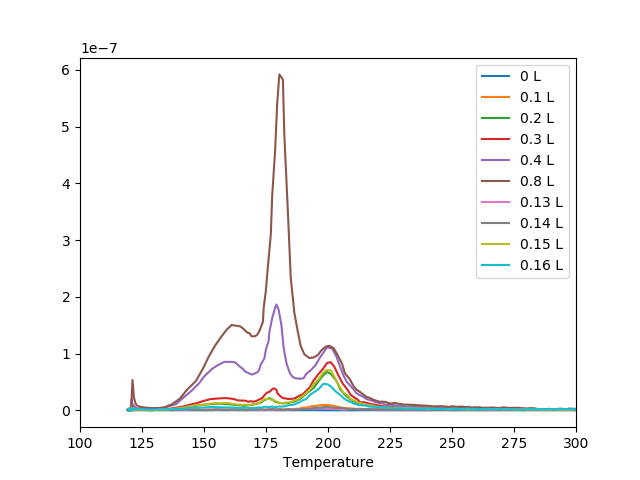

(100, 300)

In [10]:
fig, ax = plt.subplots()
for i in range(len(files)):
    files[i].plot(x='Temperature', y='Furfural',ax=ax, label=files[i].name)
ax.set_xlim([100,300])
# ax.legend([files[i].name for i in range(len(file_names))])

# Edes = 51.1
# out = polanyi_wigner(T, initial_coverage, Edes, beta, order, disp=True)

<IPython.core.display.Javascript object>


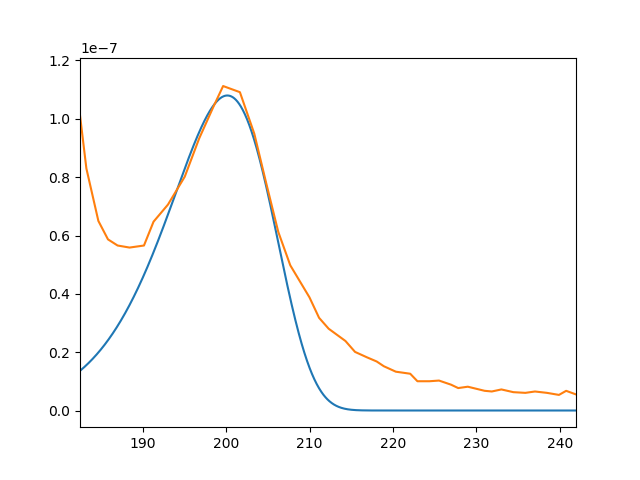

In [17]:
#  files[4] was picked randomly
fig, ax = plt.subplots()
ax.plot(T,dNdT*0.9e-20, files[4].Temperature.loc[(files[4].Temperature<500)], files[4].Furfural[(files[4].Temperature<500)])

In [14]:
"""
Let's try adding additional model peaks to the experimental spectra
"""
params['order'] = 0
params['Edes'] = 48
for Edes in np.arange(48, 55, 0.1):
    params['Edes'] = Edes
    second_peak = polanyi_wigner(T, initial_coverage, params, disp=False)
    
    if np.abs(second_peak[0][0] - 180.5) <=0.2:
        print(second_peak[0][0])
        print(params['Edes'])
        break
# second peak has Edes = 48.2 kJ/mol with 0 order desorption
for Edes in np.arange(35, 45, 0.1):
    params['Edes'] = Edes
    low_peak = polanyi_wigner(T, initial_coverage, params, disp=False)
    
    if np.abs(low_peak[0][0] - 162) <=0.2:
        print(low_peak[0][0])
        print(params['Edes'])
        break
# the lowest peak has an Edes = 43.1 kJ/mol with 0 order desorption

180.52805280528054
48.2
161.96619661966196
43.100000000000115


<IPython.core.display.Javascript object>


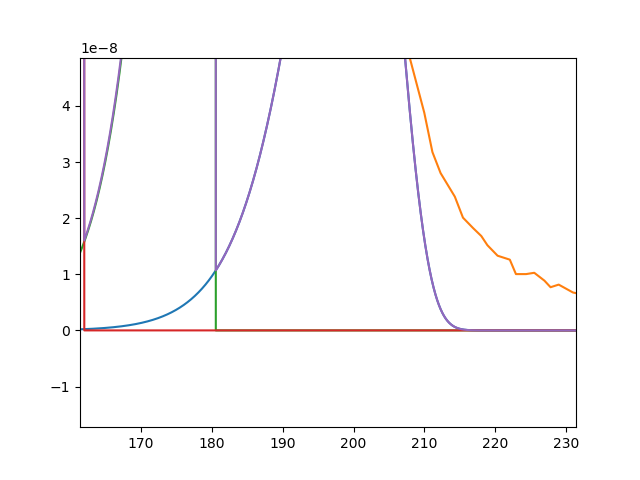

(100, 240)

In [18]:
fig, ax = plt.subplots()
ax.plot(T,dNdT*1e-20)
ax.plot(files[4].Temperature.loc[(files[4].Temperature<500)], files[4].Furfural[(files[4].Temperature<500)])
ax.plot(second_peak[1], second_peak[2]*1.65e-20)
ax.plot(low_peak[1], low_peak[2]*0.45e-20)

combined = dNdT*1e-20 + second_peak[2]*1.65e-20 + low_peak[2]*0.45e-20

ax.plot(T, combined)
ax.set_xlim([100, 240])

<IPython.core.display.Javascript object>


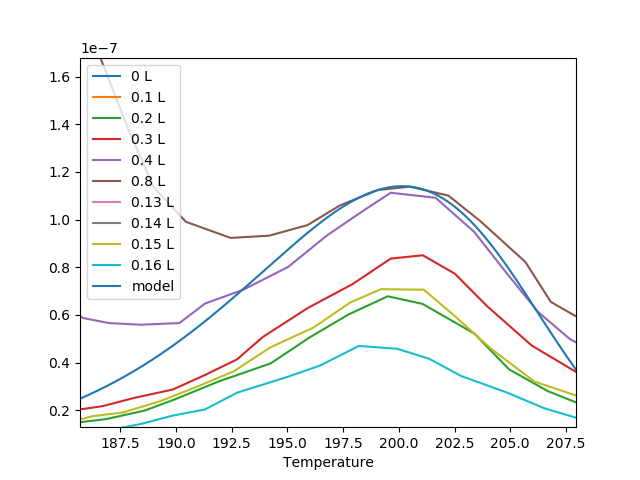

In [94]:
fig, ax = plt.subplots()
for i in range(len(files)):
    files[i].plot(x='Temperature', y='Furfural',ax=ax, label=files[i].name)
ax.set_xlim([120,240])
combined = dNdT*0.95e-20 + second_peak[2]*0.5e-20 + low_peak[2]*0.4e-20
ax.plot(T,combined, label='model')
ax.legend()

# TO DO: Use the low temperature shoulder from the model and the right experimental shoulder from the monolayer peak
# to subtract it away. Then do vertical line to subtract away the second peak from the low temp peak.

# Create an interpolation function from the model, then find a factor that minimizes the distance between the
# Tp of the experimental monolayer and the Tp in the model. 
# Repeat this for each experimental curve and get a list of factors

# I pick 176 K as the lower bound for the subtraction from the overall expermental data. 
# It seems like a pretty reasonable choice


Edes is: 50.95 kJ/mol


<IPython.core.display.Javascript object>


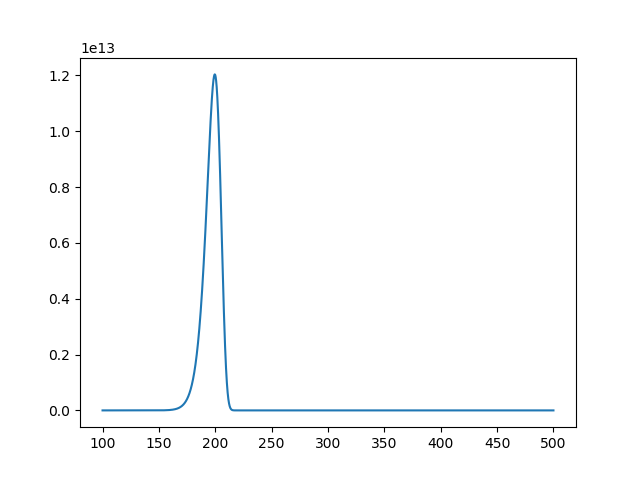

In [108]:
# Formalizing finding a model for Tp
# parameters
order = 1
Edes = 30 #kj/mol, a good value is 50
T = np.linspace(100,500,10000)
# initial_coverage=[1e15, 5e14, 2e14]
initial_coverage=[2e14]
monolayer_coverage = 1.1e15
beta = 3  # K/s
params = {'model':'None', 'Edes': Edes, 'beta': beta, 'order': order, 'A':2, 'B':3, 'C':4, 'monolayer': monolayer_coverage}
# out = polanyi_wigner(T, initial_coverage, params, disp=True)

def findMeModel(params,T, Tp, Elow, Ehigh, incr, tol, silence=True):
    """
    pass only a single array for now.
    """
    for Edes in np.arange(Elow, Ehigh, incr):
        params['Edes'] = Edes
        out = polanyi_wigner(T, initial_coverage, params, disp=False)
        if silence == False:
            print('Edes: {0:4.2f} kJ/mol, Tpeak: {1:0.2f} K'.format(Edes, out[0][0]))
        if (np.abs(out[0][0]-Tp)<= tol):
#             if silence == False:
            print('Edes is: {0:4.2f} kJ/mol'.format(Edes))
            calcEdes = Edes
            Tmax, T, dNdT = out
            return T, dNdT
        elif out[0][0]>Tp:
            print('cant find it! Maybe this one? Or reduce your tol?')
            Tmax, T, dNdT = out
            return T, dNdT
# test
T, dNdT = findMeModel(params,T, 199.6384, 50, 52, 0.05, 0.1)
fig, ax = plt.subplots()
ax.plot(T,dNdT)


In [37]:
def findMaxT(xdata, ydata, xlow, xhigh):
    """
    Finds the max in the ydata between xlow, and xhigh for the experimental data
    Finds temperature of max.
    Input data type should be a Series. Output is a numeric type.
    """
    assert type(xhigh) == float or int, 'xhigh must be a float or int'
    assert type(xlow) == float or int, 'xlow must be a float or int'
    assert xlow<xhigh, 'Consider switching xhigh and xlow'
    assert type(xdata) == pd.core.series.Series, 'xdata type is incorrect'
    assert type(ydata) == pd.core.series.Series, 'ydata type is incorrect.'
    
    idxmaxloc = ydata.loc[(xdata<xhigh) & (xdata>xlow)].idxmax()
    xlocation = xdata.iloc[idxmaxloc]
    peakIntensity = ydata.iloc[idxmaxloc]
    #     xlocation = xdata.loc[ydata.loc[peakIntensity]]
    
    return peakIntensity, xlocation

# test
findpeakbounds = [190, 210]
peak, temper  = findMaxT(files[4].Temperature, files[4].Furfural, findpeakbounds[0], findpeakbounds[1])
print(peak,temper)


1.112421094436246e-07 199.6384


4.0864018821979636e-21


<IPython.core.display.Javascript object>


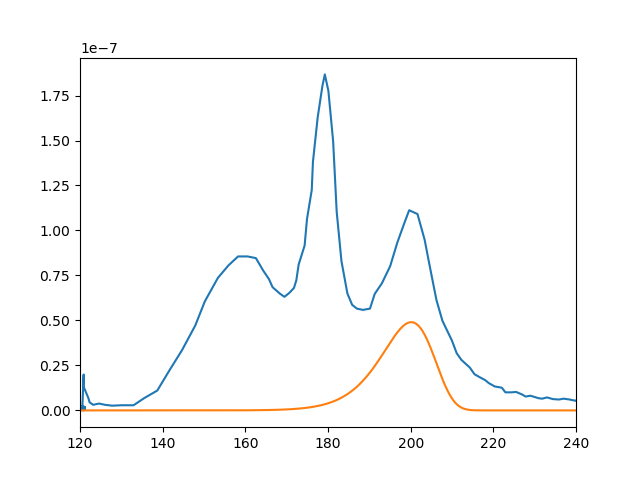

(120, 240)

In [87]:
def findFactor(experPeakIntensity, expertemperature, xmodel, ymodel):
    """
    Creates interp function of model.
    Finds the factor that multiplies the monolayerModel data to match the monolayer peak
    
    Use .squeeze() to get the shape of the array from (10000, 1) to (10000,)
    
    returns: interp function of model, factor
    """
#     print(np.shape(xmodel))
#     print(np.shape(ymodel.squeeze()))
    
#     print('xmin= ' +str(xmodel.min()))
#     print('xmax= ' +str(xmodel.max()))
    model = interpolate.interp1d(x=xmodel, y=ymodel.squeeze())
    
    factor = experPeakIntensity/model(expertemperature)
    
    return model, factor
# test
model, proportion = findFactor(peak, temper, T, dNdT)
print(proportion)
fig, ax = plt.subplots()
ax.plot(files[4].Temperature, files[4].Furfural, T, proportion*dNdT)
ax.set_xlim([120, 240])

<IPython.core.display.Javascript object>


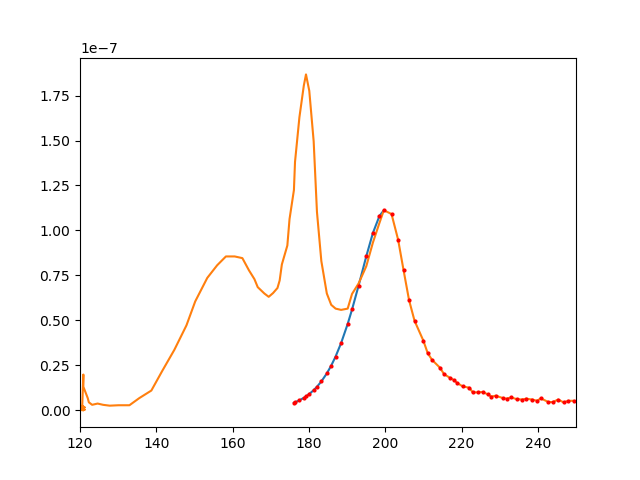

area: 2.306e-06


In [77]:
"""
Get the model's data from 176 to 250K, segement as follows:
# 'Furfural': (176,250),     --> mono
# 'Furfural': (167,Tp_mono), --> second* (calculated area after subtracting away mono)
# 'Furfural': (130,167),     --> third* 
*the 130, 167 K bounds will use a striaght line to the x-axis (can also attempt a sloped line later if necessary)


Prior to this peak decomposition, I chose the following:
# 'Furfural': (188,250), --> mono
# 'Furfural': (130,250), --> mono + multi
# 'Furfural': (150,250), --> old
""" 
xrng = files[4].Temperature.loc[(files[4].Temperature > 176) & (files[4].Temperature <=temper)]
ymodel_data = proportion*model(xrng)

concat_data = np.concatenate((ymodel_data, files[4].Furfural.loc[(files[4].Temperature > temper) & (files[4].Temperature <=250)]))
xconcat = np.concatenate((xrng,files[4].Temperature.loc[(files[4].Temperature > temper) & (files[4].Temperature <=250)]))

# integrating the monolayer
area = integrate.trapz(concat_data, x=xconcat)
print('area: {area:0.3e}'.format(area=area))

# plot
fig, ax = plt.subplots()
ax.plot(xrng, ymodel_data, files[4].Temperature, files[4].Furfural)
ax.plot(xconcat, concat_data, 'or', ms=2)
ax.set_xlim([120,250])
# now write loop over all of the curves...

<IPython.core.display.Javascript object>


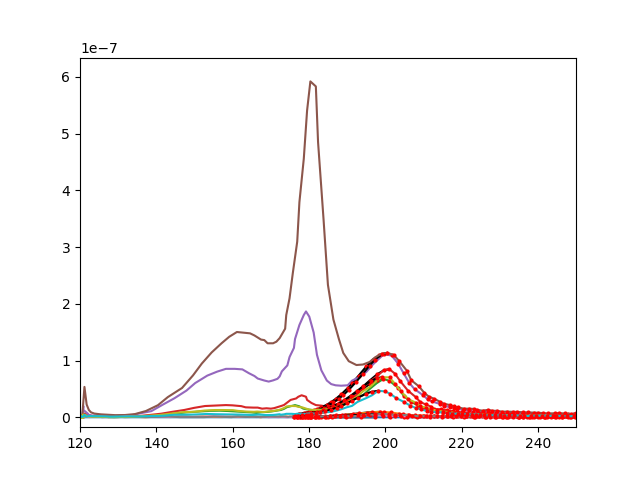

file: 0 L, temperature: 197.20
Edes is: 50.35 kJ/mol
file: 0 L, area: 1.233e-08
file: 0.1 L, temperature: 198.67
Edes is: 50.70 kJ/mol
file: 0.1 L, area: 2.404e-07
file: 0.2 L, temperature: 199.50
Edes is: 50.95 kJ/mol
file: 0.2 L, area: 1.301e-06
file: 0.3 L, temperature: 201.08
Edes is: 51.35 kJ/mol
file: 0.3 L, area: 1.605e-06
file: 0.4 L, temperature: 199.64
Edes is: 50.95 kJ/mol
file: 0.4 L, area: 2.360e-06
file: 0.8 L, temperature: 200.50
Edes is: 51.20 kJ/mol
file: 0.8 L, area: 2.495e-06
file: 0.13 L, temperature: 197.34
Edes is: 50.35 kJ/mol
file: 0.13 L, area: 1.416e-07
file: 0.14 L, temperature: 199.06
Edes is: 50.80 kJ/mol
file: 0.14 L, area: 1.694e-07
file: 0.15 L, temperature: 199.20
Edes is: 50.85 kJ/mol
file: 0.15 L, area: 1.410e-06
file: 0.16 L, temperature: 198.20
Edes is: 50.60 kJ/mol
file: 0.16 L, area: 1.002e-06


In [109]:
# Formalizing finding a model for Tp
# parameters
order = 1
Edes = 50 #kj/mol, a good value is 50
T = np.linspace(100,500,10000)
# initial_coverage=[1e15, 5e14, 2e14]
initial_coverage=[2e14]
monolayer_coverage = 1.1e15
beta = 3  # K/s
params = {'model':'None', 'Edes': Edes, 'beta': beta, 'order': order, 'A':2, 'B':3, 'C':4, 'monolayer': monolayer_coverage}
# out = polanyi_wigner(T, initial_coverage, params, disp=True)


fi = []
area=[]
x_mono = []
y_mono = []
fig, ax = plt.subplots()

for i in range(len(file_names)):
    # 1. Find Tp in experimental data

    findpeakbounds = [190, 210]
    peak, temper  = findMaxT(files[i].Temperature, files[i].Furfural, findpeakbounds[0], findpeakbounds[1])
    print('file: {files}, temperature: {temper:0.2f}'.format(files = file_names[i], temper=temper))
    # 2. Create model and find proportion factor
    T, dNdT = findMeModel(params, T, temper, 50, 52, 0.05, 0.1 )
    model, proportion = findFactor(peak, temper, T, dNdT)

    # 3. Get x,y data from model from 176 to Tp, concatenate with data from (Tp,250)
    xrng = files[i].Temperature.loc[(files[i].Temperature > 176) & (files[i].Temperature <=temper)]
    ymodel_data = proportion*model(xrng)

    concat_data = np.concatenate((ymodel_data, files[i].Furfural.loc[(files[i].Temperature > temper) & (files[i].Temperature <=250)]))
    xconcat = np.concatenate((xrng,files[i].Temperature.loc[(files[i].Temperature > temper) & (files[i].Temperature <=250)]))

    x_mono.append(xconcat)
    y_mono.append(concat_data)

    # 4. Integrate area
    
    fi.append(file_names[i])
    area.append(integrate.trapz(concat_data, x=xconcat))
    print('file: {files}, area: {area:0.3e}'.format(files = file_names[i], area=area[i]))

    # 5. Plot results.
    
    ax.plot(xrng, ymodel_data,'k', files[i].Temperature, files[i].Furfural)
    ax.plot(xconcat, concat_data, 'or', ms=2)
    ax.set_xlim([120,250])
# ax.legend([])

<IPython.core.display.Javascript object>


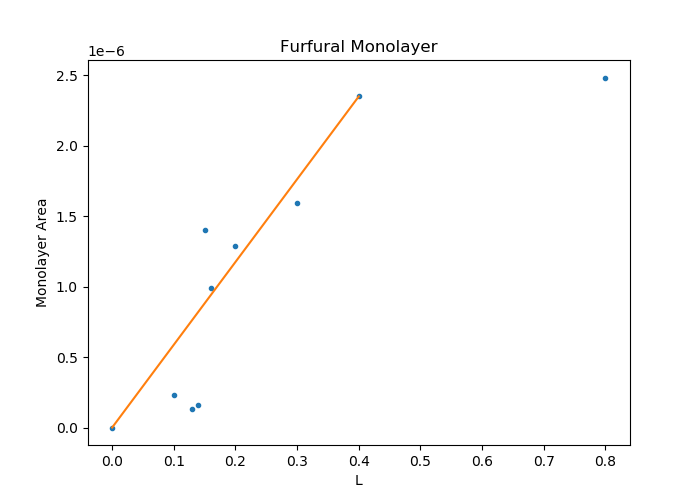

In [150]:
zero_sub_area = np.array(area-area[0])

nums = np.array([float(i.split(' ')[0]) for i in fi])
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(nums, zero_sub_area, 'o', ms=3)
ax.plot(nums[[0,4]], zero_sub_area[[0,4]])
ax.set_title('Furfural Monolayer')
ax.set_xlabel('L')
ax.set_ylabel('Monolayer Area')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# TO DO: calculate areas of second and third peaks.

In [153]:
print(area)

[1.2325452233345386e-08, 2.403752484343017e-07, 1.3006644280243831e-06, 1.6047032498001201e-06, 2.360366046611867e-06, 2.494837822117605e-06, 1.4162907414840254e-07, 1.6935303744069684e-07, 1.4101451227848244e-06, 1.0023684663298006e-06]
